In [58]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [59]:
import astropy.units as u
import matplotlib.pyplot as plt
import numpy as np
import regions
import sunpy.map

from astropy.coordinates import SkyCoord

import solar_area_calculation as sac

%matplotlib inline

# Define some basic plotting functions

In [60]:
def plot_2d(
    map_: sunpy.map.GenericMap,
    region: regions.SkyRegion
) -> tuple[plt.Figure, plt.Axes]:

    fig, ax = plt.subplots(subplot_kw=dict(projection=map_))
    map_.plot(axes=ax)
    map_.draw_limb(color='black', ls='dotted')
    ax.set(xlabel='X [arcsec]', ylabel='Y [arcsec]')
    region.to_pixel(map_.wcs).plot(ax=ax)
    ax.set_title('Region on solar disk')

    return fig, ax


def plot_3d(
    coords: np.ndarray
) -> tuple[plt.Figure, plt.Axes]:

    # Plot the 3D surface and FOV.
    fig, ax = plt.subplots(subplot_kw=dict(projection='3d'))
    ax.view_init(elev=15, azim=40)
    
    sac.mapping.plot_sphere(ax)
    # NOTE: The polygons represented by plot_surface
    # ARE NOT(!!!) the same as the polygons used to compute the
    # area. It's very expensive to store and plot those polygons
    # when the grid resolution is high.

    X, Y, Z = coords[:,:,0], coords[:,:,1], coords[:,:,2]
    ax.plot_surface(X, Y, Z, color='blue', alpha=1)
    ax.set(
        xlabel='Solar radii',
        ylabel='Solar radii',
        zlabel='Solar radii',
        title='Region projected onto solar sphere',
        xlim=(-1.1,1.1),
        ylim=(-1.1,1.1),
        zlim=(-1.1,1.1),
        box_aspect=[1,1,1]
    )
    ax.grid(False)

    return fig, ax

# Examples of various shapes

## **Note that the selection of a Sunpy `Map` object is important in determining the accuracy.**
The calculation uses the pixel grid and resolution (i.e. arcsec/pixel) to determine the area, so the resolution of this grid influences the end result.**

## Disk-centered square

This example shows how to compute the area of a disk-centered square with dimensions of 12 x 12 arcminutes.
We use an example AIA map with the data set to zero, so the map is 1024 x 1024 pixel with a scale of 2.403 arcsec / pixel.

Note also that the `Map` has a `coordinate_frame` attribute which defines the observer position.
It also contains a value for the solar radius which is used to determine the scaling.

In [61]:
map_ = sac.mapping.gen_blank_map()
# map_ = sac.mapping.example_aia_map() # Use this if you want an AIA backdrop
fov = regions.RectangleSkyRegion(
    SkyCoord(*(0, 0)*u.arcsec,frame=map_.coordinate_frame),
    width=12*u.arcmin,
    height=12*u.arcmin,
    angle=0*u.deg
)

area, coords = sac.area.compute_solar_area(
    map_,
    fov,
    resolution=1000,
    return_coordinates=True
)
area = area << u.m**2

print('map_ solar radius:', map_.coordinate_frame.rsun) # This is used when computing the area
print(f'area : {area:.6}')
print(f'area arcsec2: {area*(sac.area.SOLAR_RADIUS_ARCSECONDS/sac.area.SOLAR_RADIUS_METERS)**2:.6}')
print(f'fraction of total solar surface area: {area/sac.area.SOLAR_AREA_METERS}')

map_ solar radius: 696000.0 km
area : 2.92903e+17 m2
area arcsec2: 5.57298e+05 arcsec2
fraction of total solar surface area: 0.048158206515708735


### Plots

Make 2D and 3D plots of the geometry.
The 3D plot is representative of the polygon array used when computing the area.
**However**, they are **not** the same polygons!
The polygons are too expensive to store and plot when the resolution is high, so we just use `matplotlib`'s `plot_surface` method to do this.

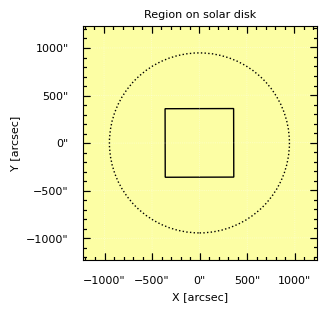

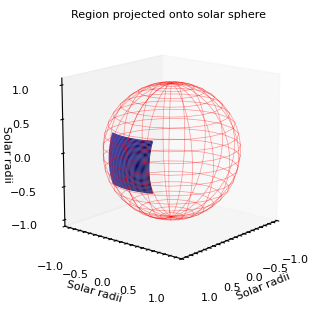

In [62]:
fig, ax = plot_2d(map_, fov)
fig, ax = plot_3d(coords)

### 3D animation

In [63]:
ax.set_axis_off()
sac.mapping.sphere_mosaic(fig, ax, 'mosaic.gif')

Sphere mosaic saved to mosaic.gif


## Disk-edge ellipse

In [64]:
map_ = sac.mapping.gen_blank_map()
# map_ = sac.mapping.example_aia_map()
fov = regions.EllipseSkyRegion(
    SkyCoord(*(300, 600)*u.arcsec,frame=map_.coordinate_frame),
    width=12*u.arcmin,
    height=20*u.arcmin,
    angle=30*u.deg
)

area, coords = sac.area.compute_solar_area(
    map_,
    fov,
    resolution=1000,
    return_coordinates=True
)
area = area << u.m**2

print('map_ solar radius:', map_.coordinate_frame.rsun) # This is used when computing the area
print(f'area : {area:.6}')
print(f'area arcsec2: {area*(sac.area.SOLAR_RADIUS_ARCSECONDS/sac.area.SOLAR_RADIUS_METERS)**2:.6}')
print(f'fraction of total solar surface area: {area/sac.area.SOLAR_AREA_METERS}')

map_ solar radius: 696000.0 km
area : 5.54243e+17 m2
area arcsec2: 1.05454e+06 arcsec2
fraction of total solar surface area: 0.09112684721317131


### Plots

Make 2D and 3D plots of the geometry.

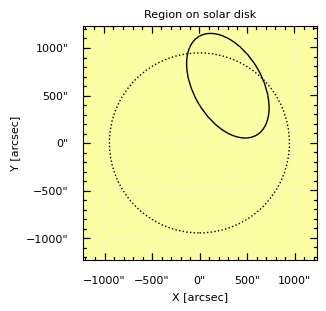

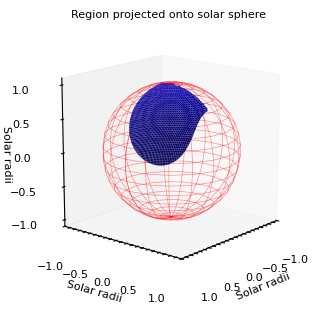

In [65]:
fig, ax = plot_2d(map_, fov)
fig, ax = plot_3d(coords)

## Random polygon

In [66]:
# map_ = sac.mapping.gen_blank_map()
map_ = sac.mapping.example_aia_map()
fov = regions.PolygonSkyRegion(
    SkyCoord([
            (-700, 800)*u.arcsec,
            (200, 650)*u.arcsec,
            (500, -500)*u.arcsec,
            (-100, -100)*u.arcsec
        ],
        frame=map_.coordinate_frame
    ),
)

area, coords = sac.area.compute_solar_area(
    map_,
    fov,
    resolution=1000,
    return_coordinates=True
)
area = area << u.m**2

print('map_ solar radius:', map_.coordinate_frame.rsun) # This is used when computing the area
print(f'area : {area:.6}')
print(f'area arcsec2: {area*(sac.area.SOLAR_RADIUS_ARCSECONDS/sac.area.SOLAR_RADIUS_METERS)**2:.6}')
print(f'fraction of total solar surface area: {area/sac.area.SOLAR_AREA_METERS}')

map_ solar radius: 696000.0 km
area : 4.25429e+17 m2
area arcsec2: 8.09451e+05 arcsec2
fraction of total solar surface area: 0.06994762793864832


### Plots

Make 2D and 3D plots of the geometry.

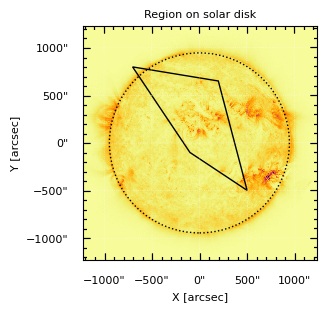

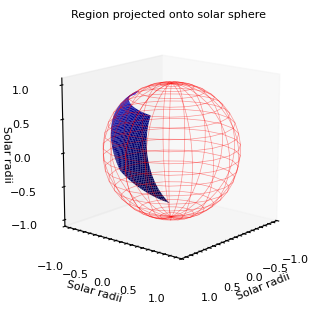

In [67]:
fig, ax = plot_2d(map_, fov)
fig, ax = plot_3d(coords)

## Full disk

In [68]:
# map_ = sac.mapping.gen_blank_map()
map_ = sac.mapping.example_aia_map()
fov = regions.CircleSkyRegion(
    SkyCoord(*(0,0)*u.arcsec,frame=map_.coordinate_frame),
    radius=32*u.arcmin
)

area, coords = sac.area.compute_solar_area(
    map_,
    fov,
    resolution=1000,
    return_coordinates=True
)
area = area << u.m**2

print('map_ solar radius:', map_.coordinate_frame.rsun) # This is used when computing the area
print(f'area : {area:.6}')
print(f'area arcsec2: {area*(sac.area.SOLAR_RADIUS_ARCSECONDS/sac.area.SOLAR_RADIUS_METERS)**2:.6}')
print(f'fraction of total solar surface area: {area/sac.area.SOLAR_AREA_METERS}')

map_ solar radius: 696000.0 km
area : 2.85671e+18 m2
area arcsec2: 5.43538e+06 arcsec2
fraction of total solar surface area: 0.469690872268864


### Plots

Make 2D and 3D plots of the geometry.

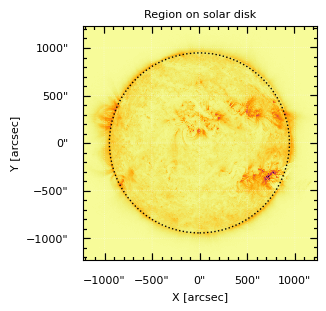

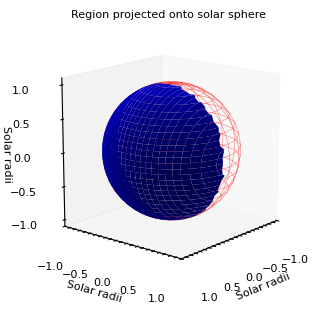

In [69]:
fig, ax = plot_2d(map_, fov)
fig, ax = plot_3d(coords)